In [54]:
import os
fullpth = os.path.abspath(os.path.curdir)
while os.path.basename(os.path.abspath(os.path.curdir)) != 'multi-instance-mask-rcnn-extension':
    %cd ../

In [146]:
SKIP_NEW = False
ONLY_LAST_SAVED = True

import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from pprint import pprint
import torch

traindir_roots = glob('/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07*')
traindir_roots.extend(glob('/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-06*'))
traindir_roots.append('/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/maskrcnninit')

def decompose_cocoeval_file(filepath):
    assert os.path.exists(filepath), filepath + ' does not exist'
    print(f"Loading {filepath}")
    d = torch.load(filepath)
    decomp_dir = filepath.replace('.pth', '-decomp/')
    if os.path.exists(decomp_dir):
        print(f"Warning: directory already exists.")
    else:
        os.makedirs(decomp_dir)
    for taskname in d.keys():
        outname = os.path.join(decomp_dir, '-'.join(x for x in taskname) + '.pth')
        print(f"Saving {outname}")
        torch.save(d[taskname], outname)

traindirs = {}
for d in traindir_roots:
    lst = sorted(glob(os.path.join(d, 'coco_2017_val', 'itr*')))
    iterations = [int(os.path.basename(l).replace('itr', '')) for l in lst]
    if len(iterations) == 0:
        continue
    if ONLY_LAST_SAVED:
        last_saved = np.argmax(iterations)
        lst = [lst[last_saved]]
        iterations = [iterations[last_saved]]
    if max(iterations) == 0:
        if 'maskrcnninit' not in lst[0]:
            continue
    for i, l in zip(iterations, lst):
        if not os.path.exists(os.path.join(l, 'cocoevals-decomp/')):
            print('Decomposing the cocoeval file')
            decompose_cocoeval_file(os.path.join(l, 'cocoevals.pth'))
        task_segm_files = glob(os.path.join(l, 'cocoevals-decomp/*-segm.pth'))
        tasks = [os.path.splitext(os.path.basename(t))[0] for t in task_segm_files]
        traindirs[(os.path.basename(d), i)] = {t: f for t, f in zip(tasks, task_segm_files)}


In [147]:
for k in traindirs.keys():
    print(k[0])

train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0
train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-standard
train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-1
train_2021-07-20-202510_VCS-2dbaca2_MAX_ITR-100000_HEAD_TYPE-None
train_2021-07-05-131801_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-standard
train_2021-06-19-172035_VCS-812882b_MAX_ITR-100000_HEAD_TYPE-standard
train_2021-06-17-095941_VCS-2dbaca2_MAX_ITR-100000_HEAD_TYPE-None
train_2021-06-16-154242_VCS-f165af5_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0
train_2021-06-17-220419_VCS-2dbaca2_MAX_ITR-100000_HEAD_TYPE-None
train_2021-06-21-081134_VCS-3b1367f_MAX_ITR-100000_HEAD_TYPE-standard
train_2021-06-19-011917_VCS-776a559_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0
train_2021-06-20-184444_VCS-3b1367f_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0
train_2021-06-16-103924_VCS-f165af5_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0
train_2021-06-18-121620_VCS-2dbaca2_MAX_ITR-100000_HEAD_TYPE-None


In [148]:
import pandas as pd

# Compile stats by category; store imageids in a separate indexing list

def get_df_agg_from_cocoeval(evalImgs, params):
    N = len(params.imgIds)  # number of images
    C = len(params.catIds)
    A = len(params.areaRng)

    def getimcatareaid(imidx, areaidx, catidx):
        return A*N*k + N*j + i

    agg = {'ious_bygt': {},
           'gtids': {},
           'dt_fp': {},
           'gt_missed': {}
          }
    imcatarea_df_fp = []
    imcatarea_df_fn = []
    imcatarea_df_tp = []
    imcatarea_imgId = []
    imcatarea_catId = []
    imcatarea_ninst = []
    imcatarea_areaRng = []
    inst_df_iou = []
    inst_df_gtid = []
    inst_df_catId = []
    inst_df_imgId = []
    inst_df_areaRng = []
    for k, catid in enumerate(params.catIds):
        for j, arng in enumerate(params.areaRng[:1]):
            for i, imgid in enumerate(params.imgIds):
                imcatareaidx = getimcatareaid(i, j, k)
#                 print(i, j, k, imcatareaidx)
                if evalImgs[imcatareaidx] is not None:
                    n_inst = len(evalImgs[imcatareaidx]['gtIds'])
                    assert (evalImgs[imcatareaidx]['image_id'], evalImgs[imcatareaidx]['category_id'], evalImgs[imcatareaidx]['aRng']) == (imgid, catid, arng)
                    inst_df_iou.extend(evalImgs[imcatareaidx]['gtMatchIous'][0, :])
                    inst_df_gtid.extend(evalImgs[imcatareaidx]['gtIds'])
                    inst_df_catId.extend([catid for _ in range(n_inst)])
                    inst_df_imgId.extend([imgid for _ in range(n_inst)])
                    inst_df_areaRng.extend([arng for _ in range(n_inst)])
                    fp = sum(x == 0 for x in evalImgs[imcatareaidx]['dtMatches'][0, :])
                    tp = sum(x != 0 for x in evalImgs[imcatareaidx]['gtMatches'][0, :])
                    fn = sum(x == 0 for x in evalImgs[imcatareaidx]['gtMatches'][0, :])
                    ninst = len(evalImgs[imcatareaidx]['gtIds'])
                else:
                    fp, tp, fn = -1, -1, -1
                    ninst = 0
                imcatarea_df_fp.append(fp)
                imcatarea_df_fn.append(fn)
                imcatarea_df_tp.append(tp)
                imcatarea_imgId.append(imgid)
                imcatarea_catId.append(catid)
                imcatarea_areaRng.append(arng)
                imcatarea_ninst.append(ninst)


    inst_df = pd.DataFrame(
        data={
        'iou': inst_df_iou, 
        'gtid': inst_df_gtid,
        'category_id': inst_df_catId,
        'image_id': inst_df_imgId,
        'aRng': inst_df_areaRng
    }, index=None)
    imcatarea_df = pd.DataFrame(
        data={
            'fp': imcatarea_df_fp,
            'tp': imcatarea_df_tp,
            'fn': imcatarea_df_fn,
            'image_id': imcatarea_imgId,
            'n_inst': imcatarea_ninst,
        }, index=None)
    return inst_df, imcatarea_df


In [149]:
traindirs

{('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0',
  144000): {'pred_masks1-segm': '/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr144000/cocoevals-decomp/pred_masks1-segm.pth',
  'agg-pred_masks1_pred_masks2-segm': '/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr144000/cocoevals-decomp/agg-pred_masks1_pred_masks2-segm.pth',
  'pred_masks-segm': '/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr144000/cocoevals-decomp/pred_masks-segm.pth',
  'pred_masks2-segm': '/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coc

In [150]:
# Load cocoevals and convert to dataframes if not cached.

cocoevals = {}
i = 0
df_csv_names = {}
for k, v in traindirs.items():
    i += 1
    print(f"{i}/{len(traindirs)}")
    cocoeval = {}
    for k1, v1 in v.items():
        inst_df_csv_name = v1.replace('.pth', '-df-inst.csv')
        imcatarea_df_csv_name = v1.replace('.pth', '-df-imcatarea.csv')
        df_csv_names[(k, k1)] = {'inst': inst_df_csv_name, 'imcatarea': imcatarea_df_csv_name}

inst_dfs = {}
imcatarea_dfs = {}
bad_keys = []
i = 0
for (k, k1), csv_names in df_csv_names.items():
    i += 1
    if not all(os.path.exists(v) for v in csv_names.values()):
        print(f"loading {i}/{len(csv_names)} from {traindirs[k][k1]}")
        try:
            cocoeval = torch.load(traindirs[k][k1])
        except Exception as ex:
            bad_keys.append((k, k1))
            print(f"FAILED Loading from {traindirs[k][k1]}")
            print(ex)
            continue
        inst_df_, imcatarea_df_ = get_df_agg_from_cocoeval(cocoeval.evalImgs, cocoeval.params)
        print(inst_df_)
        inst_df_.to_csv(csv_names['inst'])
        imcatarea_df_.to_csv(csv_names['imcatarea'])
    else:
        print('Files already exist:')
        for v in csv_names.values():
            print(v)    
    i += 1
for (k, k1) in bad_keys:
    del df_csv_names[(k, k1)]
print('Done')


1/18
2/18
3/18
4/18
5/18
6/18
7/18
8/18
9/18
10/18
11/18
12/18
13/18
14/18
15/18
16/18
17/18
18/18
Files already exist:
/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr144000/cocoevals-decomp/pred_masks1-segm-df-inst.csv
/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr144000/cocoevals-decomp/pred_masks1-segm-df-imcatarea.csv
Files already exist:
/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr144000/cocoevals-decomp/agg-pred_masks1_pred_masks2-segm-df-inst.csv
/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr144000/cocoevals-de

FAILED Loading from /home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/maskrcnninit/coco_2017_val/itr0/cocoevals-decomp/agg-pred_masks-segm.pth
pickle data was truncated
Done


In [151]:
import pandas as pd

inst_dfs = {}
imcatarea_dfs = {}
for (k, k1), csv_names in df_csv_names.items():
    print(f"Loading ({k}, {k1})")
    inst_df = pd.read_csv(csv_names['inst'])
    imcatarea_df = pd.read_csv(csv_names['imcatarea'])
    inst_dfs[(k, k1)] = inst_df
    imcatarea_dfs[(k, k1)] = imcatarea_df

NA_column = 'Unnamed: 0'
for k_ in imcatarea_dfs.keys():
    if NA_column in imcatarea_dfs[k_].columns:
        imcatarea_dfs[k_] = imcatarea_dfs[k_].drop(NA_column, axis=1)
    if NA_column in inst_dfs[k_].columns:
        inst_dfs[k_] = inst_dfs[k_].drop(NA_column, axis=1)

n_inst = None
for k, df_ in inst_dfs.items():
    if n_inst is None:
        n_inst = len(df_)
    else:
        assert n_inst == len(df_)
    if 'model_type' in df_:
        df_ = df_.drop('model_type', axis=1)
    df_.insert(1, 'model_type', k[0][0])
    if 'itr' in df_:
        df_ = df_.drop('itr', axis=1)
    df_.insert(2, 'itr', k[0][1])
    if 'task' in df_:
        df_ = df_.drop('task', axis=1)
    df_.insert(3, 'task', k[1])
    if 'full_exp_id' in df_:
        df_ = df_.drop('full_exp_id', axis=1)
    df_.insert(len(df_.columns), 'full_exp_id', f"{k}")
#     df_['exp_id'] = k

inst_df_all = pd.concat(inst_dfs.values())

full_exp_ids = inst_df_all.full_exp_id.unique()
for exp_id in full_exp_ids:
    assert sum(inst_df_all.full_exp_id == exp_id) == n_inst
print(f"{n_inst} per val, as expected.")

Loading (('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 144000), pred_masks1-segm)
Loading (('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 144000), agg-pred_masks1_pred_masks2-segm)
Loading (('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 144000), pred_masks-segm)
Loading (('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 144000), pred_masks2-segm)
Loading (('train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-standard', 64000), pred_masks-segm)
Loading (('train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-standard', 64000), agg-pred_masks-segm)
Loading (('train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-1', 64000), pred_masks1-segm)
Loading (('train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-1', 64000), agg-pred_masks1_pred_masks2-segm)
Loading (('train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-

In [152]:
inst_df_all

,iou,model_type,itr,task,gtid,category_id,image_id,aRng,full_exp_id
0,0.596747,train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-10...,144000,pred_masks1-segm,230831,1,139,"[0, 10000000000.0]",(('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR...
1,0.813187,train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-10...,144000,pred_masks1-segm,233201,1,139,"[0, 10000000000.0]",(('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR...
2,0.753835,train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-10...,144000,pred_masks1-segm,442619,1,785,"[0, 10000000000.0]",(('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR...
3,0.000000,train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-10...,144000,pred_masks1-segm,559508,1,872,"[0, 10000000000.0]",(('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR...
4,0.655837,train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-10...,144000,pred_masks1-segm,560228,1,872,"[0, 10000000000.0]",(('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR...
...,...,...,...,...,...,...,...,...,...
36776,0.000000,maskrcnninit,0,pred_masks-segm,343676,90,563281,"[0, 10000000000.0]","(('maskrcnninit', 0), 'pred_masks-segm')"
36777,0.000000,maskrcnninit,0,pred_masks-segm,342046,90,569917,"[0, 10000000000.0]","(('maskrcnninit', 0), 'pred_masks-segm')"
36778,0.000000,maskrcnninit,0,pred_masks-segm,342886,90,569917,"[0, 10000000000.0]","(('maskrcnninit', 0), 'pred_masks-segm')"
36779,0.000000,maskrcnninit,0,pred_masks-segm,342460,90,578922,"[0, 10000000000.0]","(('maskrcnninit', 0), 'pred_masks-segm')"


In [153]:
logdirs = {}
for k in df_csv_names.keys():
    logdirs[k] = df_csv_names[k]['inst'].split('cocoevals-decomp')[0]

In [154]:
# del pdanalysis
import pandas as pd
# from multimaskextension.analysis.pdanalysis import get_datetime, findDiff, get_value_from_cfg, \
#     logdirs_to_df, inplace_augment_df_with_cfg_columns
from multimaskextension.analysis import pdanalysis
df = pd.DataFrame(dict(logdir=logdirs.values(), config_file=[os.path.join(x, 'config_resume.yaml') for x in logdirs.values()]))
pdanalysis.inplace_augment_df_with_cfg_columns(df, auto_diffcfg_columns=True, manual_cfg_allowdict=None,
                                        cf_name='config_file', blocklist=(('DATALOADER', 'SEED')))


/home/adelgior/code/multi-instance-mask-rcnn-extension/multimaskextension/analysis/pdanalysis.py:66: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  all_cfgs = {config_file: yaml.load(open(config_file, 'rb')) for config_file in df[cf_name]}


{'DATALOADER-REPEAT_THRESHOLD': ('DATALOADER', 'REPEAT_THRESHOLD'),
 'DATALOADER-SAMPLER_TRAIN': ('DATALOADER', 'SAMPLER_TRAIN'),
 'DATALOADER-SEED': ('DATALOADER', 'SEED'),
 'MODEL-ROI_HEADS-NAME': ('MODEL', 'ROI_HEADS', 'NAME'),
 'MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD': ('MODEL',
  'ROI_MASK_HEAD',
  'INIT_ACTIVATED_MASK_HEAD'),
 'MODEL-ROI_MASK_HEAD-MATCHING_LOSS': ('MODEL',
  'ROI_MASK_HEAD',
  'MATCHING_LOSS'),
 'MODEL-ROI_MASK_HEAD-N_MASKS_PER_ROI': ('MODEL',
  'ROI_MASK_HEAD',
  'N_MASKS_PER_ROI'),
 'MODEL-ROI_MASK_HEAD-REINIT_MASK_HEAD': ('MODEL',
  'ROI_MASK_HEAD',
  'REINIT_MASK_HEAD'),
 'MODEL-ROI_MASK_HEAD-WEIGHTS_RANDOM_INIT_PRIMARY': ('MODEL',
  'ROI_MASK_HEAD',
  'WEIGHTS_RANDOM_INIT_PRIMARY'),
 'MODEL-ROI_MASK_HEAD-WEIGHTS_RANDOM_INIT_SECONDARY': ('MODEL',
  'ROI_MASK_HEAD',
  'WEIGHTS_RANDOM_INIT_SECONDARY'),
 'MODEL-WEIGHTS': ('MODEL', 'WEIGHTS'),
 'SEED': ('SEED',),
 'SOLVER-MAX_ITER': ('SOLVER', 'MAX_ITER')}

In [155]:
logdirs

{(('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0',
   144000),
  'pred_masks1-segm'): '/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr144000/',
 (('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0',
   144000),
  'agg-pred_masks1_pred_masks2-segm'): '/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr144000/',
 (('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0',
   144000),
  'pred_masks-segm'): '/home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr144000/',
 (('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0',
   144000),
  'pred_mask

In [156]:
df['logdir_base'] = [os.path.basename(os.path.dirname(os.path.dirname(x.rstrip('/')))) for x in df.logdir]

In [157]:
df = df.drop_duplicates()
df

,logdir,config_file,DATALOADER-REPEAT_THRESHOLD,DATALOADER-SAMPLER_TRAIN,DATALOADER-SEED,MODEL-ROI_HEADS-NAME,MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD,MODEL-ROI_MASK_HEAD-MATCHING_LOSS,MODEL-ROI_MASK_HEAD-N_MASKS_PER_ROI,MODEL-ROI_MASK_HEAD-REINIT_MASK_HEAD,MODEL-ROI_MASK_HEAD-WEIGHTS_RANDOM_INIT_PRIMARY,MODEL-ROI_MASK_HEAD-WEIGHTS_RANDOM_INIT_SECONDARY,MODEL-WEIGHTS,SEED,SOLVER-MAX_ITER,logdir_base
0,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,11.0,MultiROIHeadsAPD,custom,False,2,True,None,None,output/logs/train/train_2021-07-03-221550_VCS-...,1,100000,train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-10...
4,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,11.0,MultiROIHeadsAPD,standard,False,2,True,None,None,output/logs/train/train_2021-07-03-221541_VCS-...,1,100000,train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-10...
6,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,11.0,MultiROIHeadsAPD,custom,True,2,True,None,None,output/logs/train/train_2021-07-03-221541_VCS-...,1,100000,train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-10...
10,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.02,TrainingSampler,11.0,StandardROIHeads,standard,False,1,False,None,None,output/logs/train/train_2021-07-20-202510_VCS-...,-1,100000,train_2021-07-20-202510_VCS-2dbaca2_MAX_ITR-10...
12,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,11.0,MultiROIHeadsAPD,standard,False,2,True,None,None,output/logs/train/train_2021-07-05-131801_VCS-...,1,100000,train_2021-07-05-131801_VCS-fecca4a_MAX_ITR-10...
14,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,11.0,MultiROIHeadsAPD,standard,False,1,None,True,True,output/logs/train/train_2021-06-19-172035_VCS-...,1,100000,train_2021-06-19-172035_VCS-812882b_MAX_ITR-10...
16,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.10,GeneralizedRepeatFactorTrainingSampler,11.0,StandardROIHeads,standard,False,1,None,True,True,output/logs/train/train_2021-06-17-095941_VCS-...,-1,100000,train_2021-06-17-095941_VCS-2dbaca2_MAX_ITR-10...
18,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.02,TrainingSampler,11.0,MultiROIHeadsAPD,custom,False,1,None,True,True,output/logs/train/train_2021-06-16-154242_VCS-...,-1,100000,train_2021-06-16-154242_VCS-f165af5_MAX_ITR-10...
22,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.10,GeneralizedRepeatFactorTrainingSampler,11.0,StandardROIHeads,standard,False,1,None,True,True,output/logs/train/train_2021-06-17-220419_VCS-...,-1,100000,train_2021-06-17-220419_VCS-2dbaca2_MAX_ITR-10...
24,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.00,TrainingSampler,11.0,MultiROIHeadsAPD,standard,False,1,None,True,True,output/logs/train/train_2021-06-21-081134_VCS-...,1,100000,train_2021-06-21-081134_VCS-3b1367f_MAX_ITR-10...


In [158]:
dftmp = df[df['DATALOADER-SAMPLER_TRAIN'] == 'GeneralizedRepeatFactorTrainingSampler']
dftmp = dftmp[dftmp['MODEL-ROI_HEADS-NAME'] == 'MultiROIHeadsAPD']
# dftmp = dftmp[dftmp['MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD'] == 'custom']
# dftmp = dftmp[dftmp['MODEL-ROI_MASK_HEAD-MATCHING_LOSS'] == False]
dftmp = dftmp[dftmp['DATALOADER-REPEAT_THRESHOLD'] == 0.01]
dftmp



,logdir,config_file,DATALOADER-REPEAT_THRESHOLD,DATALOADER-SAMPLER_TRAIN,DATALOADER-SEED,MODEL-ROI_HEADS-NAME,MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD,MODEL-ROI_MASK_HEAD-MATCHING_LOSS,MODEL-ROI_MASK_HEAD-N_MASKS_PER_ROI,MODEL-ROI_MASK_HEAD-REINIT_MASK_HEAD,MODEL-ROI_MASK_HEAD-WEIGHTS_RANDOM_INIT_PRIMARY,MODEL-ROI_MASK_HEAD-WEIGHTS_RANDOM_INIT_SECONDARY,MODEL-WEIGHTS,SEED,SOLVER-MAX_ITER,logdir_base
0,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,11.0,MultiROIHeadsAPD,custom,False,2,True,None,None,output/logs/train/train_2021-07-03-221550_VCS-...,1,100000,train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-10...
4,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,11.0,MultiROIHeadsAPD,standard,False,2,True,None,None,output/logs/train/train_2021-07-03-221541_VCS-...,1,100000,train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-10...
6,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,11.0,MultiROIHeadsAPD,custom,True,2,True,None,None,output/logs/train/train_2021-07-03-221541_VCS-...,1,100000,train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-10...
12,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,11.0,MultiROIHeadsAPD,standard,False,2,True,None,None,output/logs/train/train_2021-07-05-131801_VCS-...,1,100000,train_2021-07-05-131801_VCS-fecca4a_MAX_ITR-10...
14,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,11.0,MultiROIHeadsAPD,standard,False,1,None,True,True,output/logs/train/train_2021-06-19-172035_VCS-...,1,100000,train_2021-06-19-172035_VCS-812882b_MAX_ITR-10...
30,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,11.0,MultiROIHeadsAPD,custom,False,1,None,True,True,output/logs/train/train_2021-06-20-184444_VCS-...,1,100000,train_2021-06-20-184444_VCS-3b1367f_MAX_ITR-10...


In [159]:
for k in inst_dfs.keys():
    print(k)

(('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 144000), 'pred_masks1-segm')
(('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 144000), 'agg-pred_masks1_pred_masks2-segm')
(('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 144000), 'pred_masks-segm')
(('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 144000), 'pred_masks2-segm')
(('train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-standard', 64000), 'pred_masks-segm')
(('train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-standard', 64000), 'agg-pred_masks-segm')
(('train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-1', 64000), 'pred_masks1-segm')
(('train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-1', 64000), 'agg-pred_masks1_pred_masks2-segm')
(('train_2021-07-03-221541_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-1', 64000), 'pred_masks-se

In [160]:
list(inst_dfs.keys())[0][0]

('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0',
 144000)

In [196]:
# Uniform w/ DATALOADER seed
# k1 = (('train_2021-06-19-172356_VCS-3b1367f_MAX_ITR-100000_HEAD_TYPE-None', 64000), 'pred_masks-segm')
# k2 = (('train_2021-06-19-011917_VCS-776a559_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 64000), 'pred_masks1-segm')

# Non-uniform
# k1 = (('train_2021-06-19-172035_VCS-812882b_MAX_ITR-100000_HEAD_TYPE-standard', 64000), 'pred_masks-segm')
# k2 = (('train_2021-05-04-104033_VCS-af9d7dd_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 64000), 'pred_masks1-segm')
# k2 = (('train_2021-06-20-184444_VCS-3b1367f_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 36000), 'pred_masks1-segm')
# k2 = (('train_2021-05-04-103840_VCS-af9d7dd_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-1', 64000), 'pred_masks1-segm')

# New comparison
# k1 = (('train_2021-07-05-131801_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-standard', 144000), 'pred_masks-segm')
# k2 = (('train_2021-07-03-221550_VCS-fecca4a_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0', 144000), 'pred_masks1-segm')

# Comparison #3
k1 = (('maskrcnninit', 0), 'pred_masks-segm')
k2 = (('train_2021-07-20-202510_VCS-2dbaca2_MAX_ITR-100000_HEAD_TYPE-None', 64000), 'pred_masks-segm')



imcatarea_dfs[k1]
imcatarea_dfs[k2]


,fp,tp,fn,image_id,n_inst
0,0,2,0,139,2
1,-1,-1,-1,285,0
2,-1,-1,-1,632,0
3,-1,-1,-1,724,0
4,-1,-1,-1,776,0
...,...,...,...,...,...
399995,-1,-1,-1,581317,0
399996,-1,-1,-1,581357,0
399997,-1,-1,-1,581482,0
399998,-1,-1,-1,581615,0


In [197]:
k1_config = df[df.logdir_base == k1[0][0]]
k2_config = df[df.logdir_base == k2[0][0]]
pd.concat([k1_config, k2_config])

,logdir,config_file,DATALOADER-REPEAT_THRESHOLD,DATALOADER-SAMPLER_TRAIN,DATALOADER-SEED,MODEL-ROI_HEADS-NAME,MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD,MODEL-ROI_MASK_HEAD-MATCHING_LOSS,MODEL-ROI_MASK_HEAD-N_MASKS_PER_ROI,MODEL-ROI_MASK_HEAD-REINIT_MASK_HEAD,MODEL-ROI_MASK_HEAD-WEIGHTS_RANDOM_INIT_PRIMARY,MODEL-ROI_MASK_HEAD-WEIGHTS_RANDOM_INIT_SECONDARY,MODEL-WEIGHTS,SEED,SOLVER-MAX_ITER,logdir_base
46,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.01,GeneralizedRepeatFactorTrainingSampler,NaN,StandardROIHeads,custom,True,2,None,None,None,output/logs/train/dummytest/state_dict_trainer...,-1,500000,maskrcnninit
10,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,0.02,TrainingSampler,11.0,StandardROIHeads,standard,False,1,False,None,None,output/logs/train/train_2021-07-20-202510_VCS-...,-1,100000,train_2021-07-20-202510_VCS-2dbaca2_MAX_ITR-10...


In [198]:
# exp_id1 = (('HEAD_TYPE-None', 36000), 'pred_masks-segm')
# exp_id1 = (('HEAD_TYPE-None', 0), 'agg-pred_masks-segm')
# exp_id1 = (('dummy', 0), 'pred_masks-segm')
# exp_id2 = (('HEAD_TYPE-custom_MATCH-1', 36000), 'pred_masks-segm')
exp_id1 = k1
exp_id2 = k2

print(f"iou1: {exp_id1}")
print(f"iou2: {exp_id2}\n")

def subtract_ious(dfa, dfb):  # dfa.iou - dfb.iou with assertions
    assert all(dfa.gtid == dfb.gtid)
    assert len(dfa) == len(set(dfa.gtid)), 'GT IDs are not unique'
    return dfa.iou - dfb.iou

df1 = inst_df_all.loc[inst_df_all.full_exp_id == f"{exp_id1}"]
df2 = inst_df_all.loc[inst_df_all.full_exp_id == f"{exp_id2}"]
assert len(df1) > 0
diff = subtract_ious(df1, df2)  # runs assertions before subtracting

print("========= Soft score differences ==========")
print('IOU differences (iou1 - iou2):')
print('     Mean,            min,             max')
print(diff.mean(), diff.min(), diff.max())

print(f"iou1 and iou2 both had iou=0 for {((df1.iou == df2.iou) & (df2.iou == 0)).sum()} ({100 * ((df1.iou == df2.iou) & (df2.iou == 0)).sum()/len(df1):.2f}%) instances (iou1=iou2=0)")
print(f"iou1 and iou2 both had the same nonzero iou for {((df1.iou == df2.iou) & (df2.iou != 0)).sum()} instances ({100 * ((df1.iou == df2.iou) & (df2.iou != 0)).sum()/len(df1):.2f}%) (iou1=iou2!=0)")
print(f"iou1 > iou2 for {(df1.iou > df2.iou).sum()} ({100 * (df1.iou > df2.iou).sum()/len(df2):.2f}%) instances")
print(f"iou2 > iou1 for {(df2.iou > df1.iou).sum()} ({100 * (df2.iou > df1.iou).sum()/len(df1):.2f}%) instances")

iou1_missed = df1.iou == 0
iou2_missed = df2.iou == 0

iou1_found = df1.iou >= 0.5
iou2_found = df2.iou >= 0.5

assert len(df1.iou) == sum(iou1_missed) + sum(iou1_found)
assert len(df2.iou) == sum(iou2_missed) + sum(iou2_found)
assert all(df1.full_exp_id == f"{exp_id1}")
assert all(df2.full_exp_id == f"{exp_id2}")

print("(The following has passed every assertion statement I could think of):\n")

# Useful stats

print("========= Hard score differences ==========")
print(f"iou1 missed {sum(iou1_missed)} instances ({100*sum(iou1_missed)/len(iou1_missed):.2f}% of total instances)")
print(f"iou2 missed {sum(iou2_missed)} instances ({100*sum(iou2_missed)/len(iou2_missed):.2f}% of total instances)")
print(f"iou1 found* {sum(iou1_found & iou2_missed)} instances of the {sum(iou2_missed)} that iou2 missed ({100 * sum(iou1_found & iou2_missed) / sum(iou2_missed):.2f}%)")
print(f"iou2 found* {sum(iou2_found & iou1_missed)} instances of the {sum(iou1_missed)} that iou1 missed ({100 * sum(iou2_found & iou1_missed) / sum(iou1_missed):.2f}%)")

print(f"\n======== Summary ===========")

better = "iou1" if (df1.iou > df2.iou).sum() > (df2.iou > df1.iou).sum() else "iou2"
print(f"It appears {better} is better according to soft scores (direct per-instance IOU comparisons)")
print(f"\t- Better IOU on {100 * max((df2.iou > df1.iou).sum(), (df1.iou > df2.iou).sum())/len(df2):.2f}% vs {100 * min((df2.iou > df1.iou).sum(), (df1.iou > df2.iou).sum())/len(df2):.2f}% of instances ")
better = "iou1" if sum(iou1_found) >= sum(iou2_found) else "iou2"
worse = "iou2" if better == "iou1" else "iou1"
print(f"\nIt appears {better} is better according to hard scores (total recall -- TP/gtP ).")
better_recall = sum(iou1_found)/len(df1) if better == "iou1" else sum(iou2_found)/len(df1)
worse_recall = sum(iou2_found)/len(df1) if worse == "iou2" else sum(iou1_found)/len(df1)
print(f"\t- Recall: {100 * better_recall:.2f} vs {100 * worse_recall:.2f}")
iou1_imp = sum(iou1_found & iou2_missed) / sum(iou2_missed)
iou2_imp = sum(iou2_found & iou1_missed) / sum(iou1_missed)
better_imp = iou1_imp if better == "iou1" else iou2_imp
worse_imp = iou2_imp if worse == "iou2" else iou1_imp
print(f"\t- Found {100 * better_imp:.2f}% of the instances {worse} missed vs {100 * worse_imp:.2f}% vice versa")

print(f"\n*note: 'found' means IOU>=0.5 (fairly strict)")


iou1: (('maskrcnninit', 0), 'pred_masks-segm')
iou2: (('train_2021-07-20-202510_VCS-2dbaca2_MAX_ITR-100000_HEAD_TYPE-None', 64000), 'pred_masks-segm')

========= Soft score differences ==========
IOU differences (iou1 - iou2):
     Mean,            min,             max
-0.013644199693212105 -1.0 0.9962121212121212
iou1 and iou2 both had iou=0 for 12708 (34.55%) instances (iou1=iou2=0)
iou1 and iou2 both had the same nonzero iou for 1272 instances (3.46%) (iou1=iou2!=0)
iou1 > iou2 for 11328 (30.80%) instances
iou2 > iou1 for 11473 (31.19%) instances
(The following has passed every assertion statement I could think of):

========= Hard score differences ==========
iou1 missed 13615 instances (37.02% of total instances)
iou2 missed 12917 instances (35.12% of total instances)
iou1 found* 209 instances of the 12917 that iou2 missed (1.62%)
iou2 found* 907 instances of the 13615 that iou1 missed (6.66%)

======== Summary ===========
It appears iou2 is better according to soft scores (direct

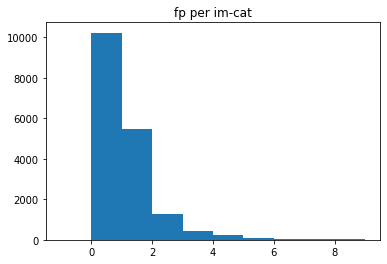

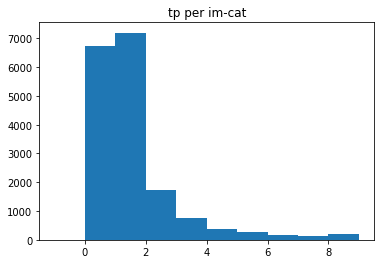

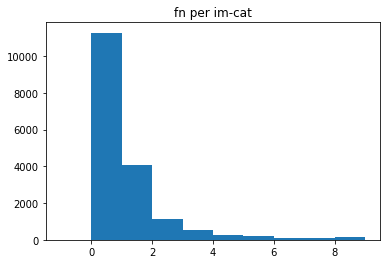

In [184]:
%matplotlib inline
import matplotlib.pyplot as plt
expid = k1
x = imcatarea_dfs[expid].fp
plt.hist(x[x!= -1], bins=np.arange(-1,10, 1)); plt.title('fp per im-cat'); plt.show()
x = imcatarea_dfs[expid].tp
plt.hist(x[x!= -1], bins=np.arange(-1,10, 1)); plt.title('tp per im-cat'); plt.show()
x = imcatarea_dfs[expid].fn
plt.hist(x[x!= -1], bins=np.arange(-1,10, 1)); plt.title('fn per im-cat'); plt.show()


In [185]:
byimid = df1[iou2_found & iou1_missed].groupby('image_id')
image_ids = list(byimid.groups)
n_found = [len(byimid.get_group(imid)) for imid in image_ids]


In [186]:
{image_ids[x]: n_found[x] for x in np.argsort(n_found)[::-1]}


{416991: 4,
 376307: 4,
 289938: 4,
 78959: 4,
 170545: 4,
 179392: 3,
 500478: 3,
 560256: 3,
 179174: 3,
 260470: 3,
 440475: 3,
 494913: 3,
 92660: 3,
 256407: 3,
 182611: 3,
 482275: 3,
 396729: 3,
 500257: 3,
 218362: 3,
 572555: 3,
 272566: 3,
 157390: 3,
 502229: 2,
 95786: 2,
 104612: 2,
 479030: 2,
 520264: 2,
 479248: 2,
 190753: 2,
 515025: 2,
 97585: 2,
 60363: 2,
 512476: 2,
 64523: 2,
 77460: 2,
 509260: 2,
 206271: 2,
 66841: 2,
 207844: 2,
 334719: 2,
 476787: 2,
 217753: 2,
 336658: 2,
 104669: 2,
 184791: 2,
 475484: 2,
 397354: 2,
 419653: 2,
 419882: 2,
 413689: 2,
 424135: 2,
 158744: 2,
 160728: 2,
 160772: 2,
 405279: 2,
 432898: 2,
 137727: 2,
 434247: 2,
 278463: 2,
 442993: 2,
 374982: 2,
 447314: 2,
 166478: 2,
 170116: 2,
 455597: 2,
 179642: 2,
 179898: 2,
 182441: 2,
 379800: 2,
 57149: 2,
 187144: 2,
 376625: 2,
 375278: 2,
 224664: 2,
 435081: 2,
 302452: 2,
 50896: 2,
 290163: 2,
 289741: 2,
 307074: 2,
 567898: 2,
 17714: 2,
 293324: 2,
 8277: 2,
 5707

In [187]:
df1_sorted = df1.loc[diff.argsort().values, :]
df2_sorted = df2.loc[diff.argsort().values, :]
(df1_sorted.image_id== df2_sorted.image_id).all()

comparison_df1_2 = pd.DataFrame(
    {'iou2': df2_sorted['iou'],
     'iou1': df1_sorted['iou'],
     'category_id': df1_sorted['category_id'],
     'image_id': df1_sorted['image_id']
    }
)

comparison_by_imageid = comparison_df1_2.groupby('image_id')

image_ids = list(comparison_by_imageid.groups)
img_agg = pd.DataFrame({'image_id': image_ids})
img_agg['max_1v2'] = 0
img_agg['min_1v2'] = 0

im_id_diffs = []
for i, im_id in enumerate(image_ids):
    compdf = comparison_by_imageid.get_group(im_id)
    diff1v2 = compdf.iou1 - compdf.iou2
    img_agg.loc[i, 'max_1v2'] = diff1v2.max()
    img_agg.loc[i, 'min_1v2'] = diff1v2.min()
    

In [188]:
outdir = os.path.expanduser('/tmp/sorting/')
if not os.path.exists(outdir):
    os.mkdir(outdir)
img_agg = img_agg.sort_values('min_1v2')
img_agg.image_id.to_csv(os.path.join(outdir, "sorted_image_id_by_min_1v2.txt"), sep='\n', index=False)
img_agg = img_agg.sort_values('max_1v2')
img_agg.image_id.to_csv(os.path.join(outdir, "sorted_image_id_by_max_1v2.txt"), index=False)
with open(os.path.join(outdir, '1_2_ids.txt'), 'w') as f:
    f.write(f"1: {exp_id1}")
    f.write(f"2: {exp_id2}")

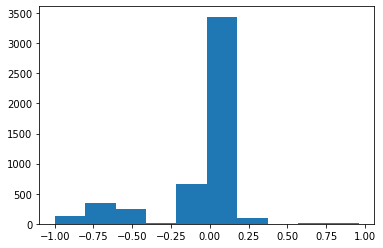

In [189]:
plt.hist(img_agg.min_1v2)
plt.show()

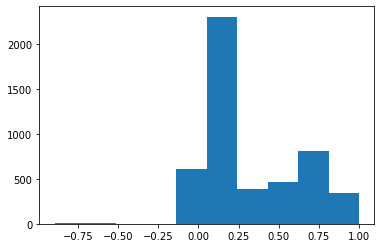

In [190]:
plt.hist(img_agg.max_1v2)
plt.show()

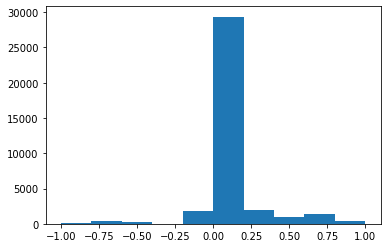

In [191]:
import matplotlib.pyplot as plt
plt.hist(diff)
plt.show()

In [192]:
# Make Histogram class for bokeh
from bokeh.models import Range1d
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_file, show, output_notebook
from bokeh.palettes import Spectral5, Turbo256
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
import itertools
from bokeh.models.widgets import Tabs, Panel
from bokeh.models import FactorRange
from bokeh.layouts import gridplot
import bokeh_catplot
import colorcet as cc


palette = [cc.rainbow[i*15] for i in range(17)]

class BokehHistogram():
    default_bins = 30
    def __init__(self, colors=palette, height=600, width=600):
        self.colors = colors
        self.alpha = 0.5
        self.height = height
        self.width = width
    
    def empty_figure(self):
        return figure(plot_height=self.height, plot_width=self.width)

    @staticmethod
    def get_np_hist(data, bins=None):
        bins = bins if bins is not None else self.default_bins
        hist, edges = np.histogram(data, bins=bins)
        return hist, edges

    def hist_hover(self, dataframe, column, bins=30, log_scale=False, show_plot=False, title=None):
        bins = bins or self.default_bins
        hist, edges = self.get_np_hist(dataframe[column], bins=bins)
        hist_df = pd.DataFrame({column: hist,
                                 "left": edges[:-1],
                                 "right": edges[1:]})
        hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                               right in zip(hist_df["left"], hist_df["right"])]

        if log_scale == True:
            hist_df["log"] = np.log(hist_df[column])
            src = ColumnDataSource(hist_df)
            plot = figure(plot_height = self.height, plot_width = self.width,
                  title = title or "Histogram of {}".format(column.capitalize()),
                  x_axis_label = column.capitalize(),
                  y_axis_label = "Log Count")    
            plot.quad(bottom = 0, top = "log",left = "left", 
                right = "right", source = src, fill_color = self.colors[0], 
                line_color = "black", fill_alpha = alpha,
                hover_fill_alpha = 1.0, hover_fill_color = self.colors[1])
        else:
            src = ColumnDataSource(hist_df)
            plot = figure(plot_height = self.height, plot_width = self.width,
                  title = title or "Histogram of {}".format(column.capitalize()),
                  x_axis_label = column.capitalize(),
                  y_axis_label = "Count")
            plot.quad(bottom = 0, top = column,left = "left", 
                right = "right", source = src, fill_color = self.colors[0], 
                line_color = "black", fill_alpha = 0.7,
                hover_fill_alpha = 1.0, hover_fill_color = self.colors[1])

        hover = HoverTool(tooltips = [('Interval', '@interval'),
                                  ('Count', str("@" + column))])
        plot.add_tools(hover)

        if show_plot == True:
            show(plot)
        return plot

    def histotabs(self, dataframe, features, log_scale=False, show_plot=False):
        hists = []
        for f in features:
            h = self.hist_hover(dataframe, f, log_scale=log_scale, show_plot=show_plot)
            p = Panel(child=h, title=f.capitalize())
            hists.append(p)
        t = Tabs(tabs=hists)
        if show_plot:
            show(t)
        return t

    def filtered_histotabs(self, dataframe, feature, filter_feature, log_scale=False, show_plot=False, title=None, sync_x=True, sync_y=True, xlim=None, ylim=None):
        hists = []
        x_min, x_max, y_min, y_max = 1e9, -1e9, 1e9, -1e9
        for col in dataframe[filter_feature].unique():
            sub_df = dataframe[dataframe[filter_feature] == col]
            histo = self.hist_hover(sub_df, feature, log_scale=log_scale, show_plot=show_plot)
            if sync_y is True and ylim is None:
                hist_data, edges = self.get_np_hist(sub_df[feature], bins=self.default_bins)
                y_min, y_max = min(y_min, min(hist_data)), max(y_max, max(hist_data))
            if sync_x is True and xlim is None:
                x_min, x_max = min(x_min, min(sub_df[feature])), max(x_max, max(sub_df[feature]))
            p = Panel(child = histo, title=title or col)
            hists.append(p)
        if sync_y:
            if ylim is not None:
                y_min, y_max = ylim
            for h in hists:
                h.child.y_range=Range1d(y_min, y_max)
        if sync_x:
            if xlim is not None:
                x_min, x_max = xlim
            for h in hists:
                h.child.x_range=Range1d(x_min, x_max)

        t = Tabs(tabs=hists)
        if show_plot:
            show(t)
        return t

    
    def filtered_stacked_hist(self, dataframe, feature, filter_feature, log_scale=False, show_plot=False, sync_x=True, sync_y=True, xlim=None, ylim=None):
        hists = []
        x_min, x_max, y_min, y_max = 1e9, -1e9, 1e9, -1e9
        for col in dataframe[filter_feature].unique():
            sub_df = dataframe[dataframe[filter_feature] == col]
            histo = self.hist_hover(sub_df, feature, log_scale=log_scale, show_plot=show_plot, title=col)
            if sync_y is True and ylim is None:
                hist_data, edges = self.get_np_hist(sub_df[feature], bins=self.default_bins)
                y_min, y_max = min(y_min, min(hist_data)), max(y_max, max(hist_data))
            if sync_x is True and xlim is None:
                x_min, x_max = min(x_min, min(sub_df[feature])), max(x_max, max(sub_df[feature]))
            hists.append(histo)
            
        if sync_y:
            if ylim is not None:
                y_min, y_max = ylim
            for h in hists:
                h.y_range=Range1d(y_min, y_max)
        if sync_x:
            if xlim is not None:
                x_min, x_max = xlim
            for h in hists:
                h.x_range=Range1d(x_min, x_max)
            
        layout = gridplot([[h] for h in hists])
        t = layout
        if show_plot:
            show(t)
        return t

    def filtered_stacked_catplots(self, dataframe, feature, filter_feature, show_plot=False):
        t = bokeh_catplot.box(
            data=dataframe,
            cats=filter_feature,
            val=feature,
            plot_height = self.height, plot_width = self.width
        )
        if show_plot:
            show(t)
        return t

    def catplotlib_histogram(self, dataframe, feature, filter_feature, show_plot=False):
        t = bokeh_catplot.histogram(
            data=dataframe,
            cats=filter_feature,
            val=feature,
            plot_height = self.height, plot_width = self.width
        )
        if show_plot:
            show(t)
        return t



In [173]:
from bokeh.layouts import column, row  # for suptitle
from bokeh.models import Div      # for suptitle
output_file("filename.html")

def mask_name_order(mask_name):
    if 'agg' in mask_name:
        return 3
    elif 'pred_mask1' in mask_name:
        return 2
    elif 'pred_mask2' in mask_name:
        return 1
    elif 'pred_mask' in mask_name:
        return 10
    else:
        return 100
    
h = BokehHistogram()
h.height = 200
h.width = 800

for sync in [True, False]:
    xsync = ysync = sync
    title = Div(text=f"<h2>IOU distribution: each plot is a different trained model's mask (axes_sync={sync})</h2>", width=h.width, height=h.height // 2)
    xl = None
    if sync:
        n_gt_instances = (inst_df_all.full_exp_id == list(inst_df_all.full_exp_id)[0]).sum()
        yl = (0, n_gt_instances)
    else:
        yl = None
    multimask_hists = []
    for model_type in inst_df_all.model_type.unique():
        for itr in inst_df_all.itr.unique():
            sort_fcn = lambda xvec: [mask_name_order(x) for x in xvec]
            dfs = inst_df_all.loc[(inst_df_all.model_type == model_type) & (inst_df_all.itr == itr), :].sort_values(by='task', inplace=False, key=sort_fcn)
            if len(dfs) == 0:
                multimask_hists.append(h.empty_figure())
            else:
                multimask_hists.append(h.filtered_stacked_hist(dfs, 'iou', 'full_exp_id', log_scale=False, sync_x=xsync, sync_y=ysync, ylim=yl, xlim=xl))
    show(column(title, row(multimask_hists)))


/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to revert to original type otherwise
/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to revert to original type otherwise
/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to re

/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to revert to original type otherwise
/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to revert to original type otherwise
/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to re

/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to revert to original type otherwise
/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to revert to original type otherwise
/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to re

/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to revert to original type otherwise
/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to revert to original type otherwise
/home/adelgior/virtualenvs/pytorch4_python3/lib/python3.6/site-packages/pandas/core/sorting.py:426: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = type_of_values(result)  # try to re

KeyboardInterrupt: 

In [ ]:
# def sort_full_exp_id_strs(full_exp_id_str):
    
df_for_sorting_expids = inst_df_all.loc[:, ['full_exp_id', 'model_type', 'itr', 'task']]
df_for_sorting_expids = df_for_sorting_expids.sort_values('task', key=lambda xvec: [mask_name_order(x) for x in xvec])
df_for_sorting_expids = df_for_sorting_expids.sort_values('itr')
# df_for_sorting_expids = df_for_sorting_expids.sort_values('model_type')
df_for_sorting_expids

In [ ]:
def get_hist(df, exp_id, bins):
    ex_df = df[inst_df_all.full_exp_id == f"{exp_id}"]
    assert len(ex_df) > 0
    hist_data, edges = BokehHistogram.get_np_hist(ex_df.iou, bins=bins)
    return edges, hist_data

full_exp_ids_ordered = list(inst_df_all.full_exp_id.unique())

bins = np.linspace(-0.1, 1, 100)  # BokehHistogram.default_bins


ridge_df = pd.DataFrame({f"{ei}": get_hist(df=inst_df_all, exp_id=ei, bins=bins)[1] for ei in full_exp_ids_ordered})
n_insts = ridge_df.sum(axis=0)
ridge_df.loc[:,full_exp_ids_ordered] = ridge_df.loc[:,full_exp_ids_ordered].div(n_insts, axis=1)
sum_to_1 = ridge_df.sum(axis=0)

ridge_df = pd.concat([ridge_df, ridge_df.tail(1)], axis=0)
ridge_df.iloc[-1] = 0.0
ridge_df = ridge_df.set_index(bins, drop=True)
order = full_exp_ids_ordered
print(n_insts)
print(sum_to_1)
ridge_df = ridge_df.loc[:10, :]

ridge_df.iloc[-1] = 0.0


In [ ]:
# index_name = ridge_df.index
nd = 2
rolling_ridge_df = (
    ridge_df.rolling(nd, center=True)
    .median()
    .rolling(3 * nd, center=False)
    .mean()
    .dropna()
)

ridge_df


In [ ]:
import colorcet as cc
import numpy as np
import pandas as pd
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, BasicTickFormatter
from bokeh.plotting import figure

# output_notebook()
output_file('outfile.html')

def ridge(category, data, scale=20):
    return list(zip([category] * len(data), scale * data))

palette = [cc.rainbow[int(np.mod(i * 9, len(cc.rainbow)))] for i in range(len(order))]


source = ColumnDataSource(data=dict(x=ridge_df.index.values))
p = figure(
    y_range=order,
    plot_height=900,
    plot_width=900,
    toolbar_location=None,
    title="Histograms of IOUs",
)
p.title.text_font_size = "15pt"
p.xaxis.major_label_text_font_size = "10pt"
p.yaxis.major_label_text_font_size = "10pt"

for i, country in enumerate(order):
    y = ridge(country, ridge_df[country])
    source.add(y, country)
    p.patch(
        "x",
        country,
        color=palette[i],
        alpha=0.25,
        line_color="black",
        line_alpha=0.5,
        source=source,
    )

p.outline_line_color = None
p.background_fill_color = "#efefef"

p.xaxis.formatter = BasicTickFormatter()  #(days="%m/%d")

p.ygrid.grid_line_color = None
p.xgrid.grid_line_color = "#dddddd"
p.xgrid.ticker = p.xaxis.ticker

p.axis.minor_tick_line_color = None
p.axis.major_tick_line_color = None
p.axis.axis_line_color = None

p.y_range.range_padding = 0.85

show(p)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(ridge_df[order[4]])
plt.show()

In [ ]:
ref_model_type = 'HEAD_TYPE-None'
itr = 16000
ref_task = 'pred_masks-segm'
ref_exp = f"{((ref_model_type, itr), ref_task)}"
assert ref_exp in inst_df_all.full_exp_id.unique()
ref_df = inst_df_all[inst_df_all['full_exp_id'] == ref_exp]

diff_df = inst_df_all.copy()
diff_colname = f"iou_diff"
diff_df[diff_colname] = 0
for expid in inst_df_all.full_exp_id.unique():
    expid_rows = inst_df_all.full_exp_id == expid
    diou = subtract_ious(inst_df_all[expid_rows], ref_df)
    diff_df.loc[expid_rows, diff_colname] = diou

# t = h.filtered_stacked_hist(inst_df_all, 'iou', 'full_exp_id', log_scale=False, sync_x=True, sync_y=True)


In [ ]:
 
h = BokehHistogram()
h.height = 200
h.width = 800
t = h.filtered_stacked_hist(diff_df, diff_colname, 'full_exp_id', log_scale=False, sync_x=True, sync_y=True, xlim=xl, ylim=yl)
show(t)


In [ ]:
expid1 = 'HEAD_TYPE-None'
task1 = 'pred_masks-segm'
expid2 = 'HEAD_TYPE-custom_MATCH-0'
task2 = 'pred_masks-segm'

ttl = f"{expid1}, {task1} - {expid2} ({itr})"
h = BokehHistogram()
t = h.hist_hover(inst_df_all, 'iou', log_scale=False, title=ttl)
show(t)

In [ ]:
t = h.filtered_histotabs(inst_df_all, 'iou', 'full_exp_id', log_scale=False)
show(t)

In [ ]:
t = bokeh_catplot.box(
    data=inst_df_all,
    cats=['model_type', 'task'],
    val='iou',
    plot_height=600, plot_width=600
)
show(t)


In [ ]:
t = bokeh_catplot.strip(
    data=inst_df_all,
    cats=['model_type', 'task'],
    val='iou',
    jitter=True,
    plot_height=600, plot_width=600
)
show(t)


In [ ]:
# Sanity check that df1 and df2 match only when they should

print('ALL TRUE: ', all(inst_df1.image_id == inst_df2.image_id), all(inst_df1.gtid == inst_df2.gtid), all(imcatarea_df1.n_inst == imcatarea_df2.n_inst))
print('ALL FALSE: ', all(imcatarea_df1.tp == imcatarea_df2.tp), all(imcatarea_df1.fp == imcatarea_df2.fp), all(imcatarea_df1.fn == imcatarea_df2.fn))

In [ ]:
# Histogram of x, x1, x2
# Avg IOU difference excluding FP, TP


In [ ]:
# A: <metric difference> across categories
?pd.DataFrame

In [ ]:
# B: <metric difference> across area ranges


In [ ]:
# C: <metric difference> per category


In [ ]:
# D: <metric difference>


In [ ]:
# E: <metric difference>


In [ ]:
diff_1_2_by_imareacat['ious_bygt']

In [ ]:
# Compute gt-by-gt IOU differences

# Compute per-instance difference in ious grouped by category/imageid
def get_agg_from_cocoeval(evalImgs, params):
    N = len(params.imgIds)  # number of images
    C = len(params.catIds)
    A = len(params.areaRng)

    def getimcatareaid(imidx, areaidx, catidx):
        return A*N*k + N*j + i

    agg = {'ious_bygt': {},
           'gtids': {},
           'dt_fp': {},
           'gt_missed': {}
          }
    for k, catid in enumerate(params.catIds):
        for j, arng in enumerate(params.areaRng[:1]):
            for i, imgid in enumerate(params.imgIds):
                imcatareaidx = getimcatareaid(i, j, k)
#                 print(i, j, k, imcatareaidx)
                if evalImgs[imcatareaidx] is not None:
                    assert (evalImgs[imcatareaidx]['image_id'], evalImgs[imcatareaidx]['category_id'], evalImgs[imcatareaidx]['aRng']) == (imgid, catid, arng)
                    agg['ious_bygt'][(i, j, k)] = np.array(evalImgs[imcatareaidx]['gtMatchIous'][0, :])
                    agg['gtids'][(i, j, k)] = np.array(evalImgs[imcatareaidx]['gtIds'])
                    agg['dt_fp'][(i, j, k)] = sum(x == 0 for x in evalImgs[imcatareaidx]['dtMatches'][0, :])
                    agg['gt_missed'][(i, j, k)] = sum(x == 0 for x in evalImgs[imcatareaidx]['gtMatches'][0, :])
                    
    return agg


cocoeval1 = cocoevals[('HEAD_TYPE-custom_MATCH-1', 16000)]['pred_masks1-segm']
cocoeval2 = cocoevals[('HEAD_TYPE-custom_MATCH-1', 16000)]['agg-pred_masks1_pred_masks2-segm']

agg_1 = get_agg_from_cocoeval(cocoeval1.evalImgs, cocoeval1.params)
agg_2 = get_agg_from_cocoeval(cocoeval2.evalImgs, cocoeval2.params)


In [ ]:
def compute_diff(agg_a, agg_b):  # agg_a - agg_b
    diff_ret = {}
    for stat_k in agg_a.keys():
        assert set(agg_a[stat_k].keys()) == set(agg_b[stat_k].keys())
        diff_ret[stat_k] = {}
        for k in agg_a[stat_k].keys():
            if stat_k == 'gtids':
                assert all(agg_a[stat_k][k] == agg_b[stat_k][k])
                diff_ret[stat_k][k] = agg_a[stat_k][k]
            else:
                diff_ret[stat_k][k] = agg_a[stat_k][k] - agg_b[stat_k][k]
    return diff_ret

diff_1_2_by_imareacat = compute_diff(agg_1, agg_2)


In [ ]:
from bokeh.io import show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure

def get_blank_figure(title, **kwargs):
    plot_height=kwargs.pop('plot_height', 250)
    p = figure(plot_height=plot_height, title=title, **kwargs)
    return p


def grouped_bar(d, x_super_name, x_sub_name, y_name, title=None, factor_range=None):
    x = [(x1, x2) for x1, x2 in zip(d[x_super_name], d[x_sub_name])]
    assert len(x) == len(list(set(x))), x
    y = d[y_name]
    factor_range = factor_range or FactorRange(*sorted(x))
    x_sub_unique = list(set([x_[1] for x_ in x]))

    if 'colors' not in d:
        cmap = Spectral5 if len(x_sub_unique) <= 5 else Turbo256
        colors = [cmap[x_sub_unique.index(x_[1])] for x_ in x]
    else:
        colors = d['colors']
    source = ColumnDataSource(data=dict(x=x, y=y, color=colors, x_super=d[x_super_name], x_sub=d[x_sub_name]))

    tooltips=[(f"{(x_super_name, x_sub_name)}", "@x"), (f"{x_super_name}", "@x_super"), (f"{x_sub_name}", "@x_sub"), (f"{y_name}", "@y")]

    p = get_blank_figure(x_range=factor_range, title=title or f"{x_super_name} {y_name} by {x_sub_name}",
               tooltips=tooltips, tools="save,pan,wheel_zoom,box_zoom,reset")  # toolbar_location=None, 

    p.vbar(x='x', top='y', width=0.9, color='color', source=source)

    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None
    
    return p


In [ ]:
# ds1.ious[(139, 67)]
imcatidx = 1000
# print(ds1.evalImgs[imcatidx]['gtMatchIous'][0, :])
print(ds1.evalImgs[imcatidx]['image_id'], ds1.evalImgs[imcatidx]['category_id'])
# print(ds1.ious[(ds1.evalImgs[imcatidx]['image_id'], ds1.evalImgs[imcatidx]['category_id'])]) # DT x GT (confirmed)
print('gt', ds1.evalImgs[imcatidx]['gtIds']) # GT x DT
print('dt', ds1.evalImgs[imcatidx]['dtIds']) # GT x DT
print(ds1.ious[(ds1.evalImgs[imcatidx]['image_id'], ds1.evalImgs[imcatidx]['category_id'])].shape)
print(ds1.ious[(ds1.evalImgs[imcatidx]['image_id'], ds1.evalImgs[imcatidx]['category_id'])].max(axis=0)) # one per GT
print(ds1.evalImgs[imcatidx].keys()) # one per GT
print(ds1.evalImgs[imcatidx]) # one per GT?
